# Custom Model Huggingface Framework

## Description

- This notebook dedicated to explore how to define a custom model and train the custom model with Huggingface framework
- Useful sources:
    - [Huggingface Models](https://huggingface.co/docs/transformers/en/models)
    - [Medium Blog - A Guide to Craft Your Own Custom Hugging Face Model](https://medium.com/@edandwe/a-guide-to-craft-your-own-custom-hugging-face-model-ba9cd555a646)
- Fundamentally, there are several things to defined to start using custom model: 
    - `AutoModel` class is a convenient way to load an architecture without needing to know the exact model class name because there are many models available. It automatically selects the correct model class based on the configuration file.
    - `AutoConfig`
    - The base workflow is as follows: 
      
       ```mermaid
        flowchart LR
            A[checkpoint or local folder] --> B[config file]
            A --> D[model file]
            B --> C[config class]
            C --> E[model config]
            C --> F[model class]
            E --> G[model]
            F --> G
            G --> H[pretrained model]
            D --> H
       ```

    - More detail in this video [Instantiate a Transformers model (PyTorch)](https://www.youtube.com/watch?v=AhChOFRegn4&t=101s)
    - `PretrainedConfig` class contains all the necessary information to build a model, two things to follows:
        - 1. A custom configuration must subclass PretrainedConfig. This ensures a custom model has all the functionality of a Transformers’ model such as `from_pretrained()`, `save_pretrained()`, and `push_to_hub()`.
        - 2. The PretrainedConfig `__init__` must accept any `kwargs` and they must be passed to the superclass `__init__`.
        - > It is useful to check the validity of some of the parameters. In the example below, a check is implemented to ensure block_type and stem_type belong to one of the predefined values.
        - > Add model_type to the configuration class to enable AutoClass support.
    - `PretrainedModel` class, inheriting from PreTrainedModel and initializing the superclass with the configuration extends Transformers’ functionalities such as saving and loading to the custom model/ 
        - > Add `config_class` to the model class to enable AutoClass support.
        - NOTE: 
            - A model can return any output format. Returning a dictionary (like `ResnetModelForImageClassification`) with losses when labels are available makes the custom model compatible with [Trainer](https://huggingface.co/docs/transformers/v4.52.1/en/main_classes/trainer#transformers.Trainer).
            - For other output formats, you’ll need your own training loop or a different library for training.
    - The `AutoClass` API is a shortcut for automatically loading the correct architecture for a given model. It is convenient to enable this for users loading your custom model. It is convenient to enable this for users loading your custom model.
        - Make sure you have the `model_type` attribute (must be different from existing model types) in the configuration class and `config_class` attribute in the model class. Use the [register()](https://huggingface.co/docs/transformers/v4.52.1/en/model_doc/auto#transformers.AutoConfig.register) method to add the custom configuration and model to the [AutoClass](https://huggingface.co/docs/transformers/en/models#model-classes) API.
        - > The first argument to `AutoConfig.register()` must match the `model_type` attribute in the custom configuration class, and the first argument to `AutoModel.register()` must match the `config_class` of the custom model class.

## 0. Import Library

In [1]:
from transformers import Trainer, TrainerCallback, TrainingArguments
import evaluate
import torch
import numpy as np

## 1. Custom Model Initialization

### Configuration

#### LSTM

In [2]:
from typing import Optional
from transformers.configuration_utils import PretrainedConfig
from transformers.utils import logging


logger = logging.get_logger(__name__)

class LSTMConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`LSTMModel`]. It is used to instantiate an
    LSTM model according to the specified arguments, defining the model architecture. Instantiating a configuration
    with the defaults will yield a similar configuration to that of a basic LSTM architecture.

    Configuration objects inherit from [`PretrainedConfig`] and can be used to control the model outputs. Read the
    documentation from [`PretrainedConfig`] for more information.

    Args:
        input_size (`int`, *optional*, defaults to 34):
            The dimension of the input features. For pose estimation, this would be the number of keypoints * 2 (x,y coordinates).
        hidden_size (`int`, *optional*, defaults to 128):
            The dimension of the hidden states.
        num_layers (`int`, *optional*, defaults to 1):
            Number of recurrent layers.
        num_labels (`int`, *optional*, defaults to 6):
            The number of labels for classification.
        dropout (`float`, *optional*, defaults to 0.0):
            The dropout probability for all fully connected layers in the model.
        bidirectional (`bool`, *optional*, defaults to `False`):
            If `True`, becomes a bidirectional LSTM.
        batch_first (`bool`, *optional*, defaults to `True`):
            If `True`, then the input and output tensors are provided as (batch, seq, feature).
        proj_size (`int`, *optional*, defaults to 0):
            If > 0, will use LSTM with projections of corresponding size.
        window_size (`int`, *optional*, defaults to 32):
            The size of the sliding window for sequential data.
        learning_rate (`float`, *optional*, defaults to 0.001):
            The learning rate for training.
        initializer_range (`float`, *optional*, defaults to 0.02):
            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
        layer_norm_eps (`float`, *optional*, defaults to 1e-5):
            The epsilon used by the layer normalization layers.
        use_layer_norm (`bool`, *optional*, defaults to `False`):
            Whether to use layer normalization after the LSTM.
        use_projection (`bool`, *optional*, defaults to `True`):
            Whether to use a projection layer after LSTM.

    Example:

    ```python
    >>> from transformers import LSTMConfig, LSTMModel

    >>> # Initializing a LSTM configuration
    >>> configuration = LSTMConfig()

    >>> # Initializing a model from the configuration
    >>> model = LSTMModel(configuration)

    >>> # Accessing the model configuration
    >>> configuration = model.config
    ```"""

    model_type = "lstm"

    def __init__(
        self,
        input_size=34,
        hidden_size=128,
        num_layers=1,
        num_labels=5,
        dropout=0.0,
        bidirectional=False,
        batch_first=True,
        proj_size=0,
        window_size=16,
        learning_rate=0.001,
        initializer_range=0.02,
        layer_norm_eps=1e-5,
        use_layer_norm=False,
        use_projection=True,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_labels = num_labels
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.batch_first = batch_first
        self.proj_size = proj_size
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.use_layer_norm = use_layer_norm
        self.use_projection = use_projection

### Modelling

#### LSTM

In [3]:
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.modeling_outputs import (
    BaseModelOutput,
    SequenceClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import add_start_docstrings, add_start_docstrings_to_model_forward, logging

logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "LSTMConfig"

LSTM_PRETRAINED_MODEL_ARCHIVE_LIST = [
    # Add pretrained model identifiers here
]


class LSTMPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = LSTMConfig
    base_model_prefix = "lstm"
    supports_gradient_checkpointing = False
    _no_split_modules = ["LSTMLayer"]

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)


class LSTMLayer(nn.Module):
    """LSTM layer with optional layer normalization and dropout."""

    def __init__(self, config):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=config.input_size if hasattr(config, 'input_size') else config.hidden_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            batch_first=config.batch_first,
            dropout=config.dropout if config.num_layers > 1 else 0,
            bidirectional=config.bidirectional,
            proj_size=config.proj_size if config.proj_size > 0 else 0,
        )
        
        self.use_layer_norm = config.use_layer_norm
        if self.use_layer_norm:
            norm_size = config.hidden_size * (2 if config.bidirectional else 1)
            self.layer_norm = nn.LayerNorm(norm_size, eps=config.layer_norm_eps)
        
        self.dropout = nn.Dropout(config.dropout)

    def forward(
        self,
        input_tensor,
        hidden_states=None,
        cell_states=None,
    ):
        lstm_output, (hidden_states, cell_states) = self.lstm(
            input_tensor, 
            (hidden_states, cell_states) if hidden_states is not None else None
        )
        
        if self.use_layer_norm:
            lstm_output = self.layer_norm(lstm_output)
        
        lstm_output = self.dropout(lstm_output)
        
        return lstm_output, (hidden_states, cell_states)


LSTM_START_DOCSTRING = r"""
    This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass. Use it
    as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
    behavior.

    Parameters:
        config ([`LSTMConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

LSTM_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.FloatTensor` of shape `(batch_size, sequence_length, input_size)`):
            Input sequence tensor.
        attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


@add_start_docstrings(
    "The bare LSTM Model transformer outputting raw hidden-states without any specific head on top.",
    LSTM_START_DOCSTRING,
)
class LSTMModel(LSTMPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.lstm_layer = LSTMLayer(config)
        
        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(LSTM_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutput]:
        r"""
        Returns:

        Example:

        ```python
        >>> from transformers import LSTMConfig, LSTMModel
        >>> import torch

        >>> # Initializing a LSTM configuration
        >>> configuration = LSTMConfig()

        >>> # Initializing a model from the configuration
        >>> model = LSTMModel(configuration)

        >>> # Random input tensor (batch_size=2, sequence_length=32, input_size=34)
        >>> inputs = torch.randn(2, 32, 34)
        >>> outputs = model(inputs)
        >>> last_hidden_states = outputs.last_hidden_state
        ```"""
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        # Apply attention mask if provided
        if attention_mask is not None:
            # Expand attention mask
            attention_mask = attention_mask.unsqueeze(-1).expand_as(input_ids)
            input_ids = input_ids * attention_mask

        # Pass through LSTM
        sequence_output, (final_hidden, final_cell) = self.lstm_layer(input_ids)

        # Get the last hidden state
        if self.config.bidirectional:
            # Concatenate forward and backward hidden states
            last_hidden_state = torch.cat([final_hidden[-2], final_hidden[-1]], dim=-1)
        else:
            last_hidden_state = final_hidden[-1]

        if not return_dict:
            return (sequence_output, last_hidden_state)

        return BaseModelOutput(
            last_hidden_state=sequence_output,
            hidden_states=(last_hidden_state,) if output_hidden_states else None,
        )


@add_start_docstrings(
    """LSTM Model with a classification head on top (a linear layer on top of the hidden-states output).""",
    LSTM_START_DOCSTRING,
)
class LSTMForSequenceClassification(LSTMPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.lstm = LSTMModel(config)
        
        # Classification head
        classifier_input_size = config.hidden_size * (2 if config.bidirectional else 1)
        
        if config.use_projection:
            self.pre_classifier = nn.Linear(classifier_input_size, config.hidden_size)
            self.classifier = nn.Linear(config.hidden_size, config.num_labels)
            self.dropout = nn.Dropout(config.dropout)
        else:
            self.classifier = nn.Linear(classifier_input_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(LSTM_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).

        Returns:

        Example:

        ```python
        >>> from transformers import LSTMConfig, LSTMForSequenceClassification
        >>> import torch

        >>> # Number of labels for classification
        >>> num_labels = 6

        >>> # Initializing a LSTM configuration
        >>> configuration = LSTMConfig(num_labels=num_labels)

        >>> # Initializing a model from the configuration
        >>> model = LSTMForSequenceClassification(configuration)

        >>> # Random input tensor (batch_size=2, sequence_length=32, input_size=34)
        >>> inputs = torch.randn(2, 32, 34)
        >>> labels = torch.tensor([1, 3])

        >>> outputs = model(inputs, labels=labels)
        >>> loss = outputs.loss
        >>> logits = outputs.logits
        ```"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.lstm(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Get the last hidden state from LSTM
        if return_dict:
            # For sequence classification, we typically use the last hidden state
            sequence_output = outputs.last_hidden_state
            if len(outputs.hidden_states) > 0:
                pooled_output = outputs.hidden_states[0]  # Final hidden state
            else:
                # If hidden states not returned, use the last timestep
                pooled_output = sequence_output[:, -1, :]
        else:
            sequence_output = outputs[0]
            pooled_output = outputs[1]

        # Apply projection if configured
        if self.config.use_projection:
            pooled_output = self.pre_classifier(pooled_output)
            pooled_output = torch.relu(pooled_output)
            pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=None,  # LSTM doesn't have attention weights
        )


# Add to AutoModel registry
def register_lstm_auto_model():
    """Register the LSTM model with AutoModel."""
    try:
        from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification
        
        AutoConfig.register("lstm", LSTMConfig)
        AutoModel.register(LSTMConfig, LSTMModel)
        AutoModelForSequenceClassification.register(LSTMConfig, LSTMForSequenceClassification)
    except ImportError:
        logger.warning("Could not register LSTM model with AutoModel. Please ensure transformers is installed.")


# Register on module import
register_lstm_auto_model()

__all__ = [
    "LSTMConfig",
    "LSTMPreTrainedModel", 
    "LSTMModel",
    "LSTMForSequenceClassification",
]

## 2. Model Development

### 2.1. Create Dataset Object

In [5]:
from datasets import Dataset, Features, Value, ClassLabel
import os
import glob

landmark_dir = r'data/video_hand_focused_data/hand_landmark_flatten'
val_ratio = 0.25

# Create lists of file paths and labels
filepaths, labels = [], []
class_mapping = {
    'OH': 0,  # Open Hand
    'IH': 1,  # Intrinsic Plus
    'SF': 2,  # Straight Fist
    'HC': 3,  # Hook Hand
    'HH': 4   # Hand Close
}

# Scan through each class directory
for class_name in class_mapping.keys():
    class_dir = os.path.join(landmark_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Warning: Class directory not found: {class_dir}")
        continue
        
    # Get all .npy files (excluding metadata jsons)
    for npy_path in glob.glob(os.path.join(class_dir, '*_landmarks.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

ordered_labels = ["OH", "IH", "SF", "HC", "HH"]

class_feature = ClassLabel(names=ordered_labels)

features = Features({
    "landmark_path": Value("string"),
    "label":          class_feature
})

# Create dataset with file paths
dataset = Dataset.from_dict(
    {
      "landmark_path": filepaths,
      "label":         labels
    },
    features=features
)

# Create a function to load landmarks when needed
def load_landmarks(example):
    # Load the landmark data
    landmarks = np.load(example["landmark_path"])
    # Flatten if needed (should already be (16, 42) if flatten_keypoints=True was used)
    if landmarks.shape == (16, 21, 2):
        landmarks = landmarks.reshape(16, -1)
    example["input_ids"] = landmarks.tolist()
    
    return example

# Split the dataset
split = dataset.train_test_split(
    test_size=val_ratio, 
    shuffle=True, 
    seed=42, 
    stratify_by_column="label"
)

train_ds = split["train"]
val_ds = split["test"]

print(f"\nTrain set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")

# After loading the landmarks, remove the metadata field before training
train_ds = train_ds.map(load_landmarks, remove_columns=["landmark_path"])
val_ds = val_ds.map(load_landmarks, remove_columns=["landmark_path"])

# Rename 'label' to 'labels' for compatibility with Trainer
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")

# Build label mappings
label2id = {lab: idx for idx, lab in enumerate(ordered_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

print(f"label2id: {label2id}")
print(f"id2label: {id2label}")


Train set: 45 samples
Validation set: 15 samples


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

label2id: {'OH': 0, 'IH': 1, 'SF': 2, 'HC': 3, 'HH': 4}
id2label: {0: 'OH', 1: 'IH', 2: 'SF', 3: 'HC', 4: 'HH'}


### 2.2. Model Initialization

In [9]:
from torchinfo import summary

INPUT_SIZE = 42
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_LABELS = 5
DROPOUT = 0.2
BIDIRECTIONAL = True
BATCH_FIRST = True
WINDOW_SIZE = 16
USE_PROJECTION = True
USE_LAYER_NORM = True
OUTPUT_HIDDEN_STATES = True

config = LSTMConfig(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_labels=NUM_LABELS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL,
    batch_first=BATCH_FIRST,
    window_size=WINDOW_SIZE,
    use_projection=USE_PROJECTION,
    use_layer_norm=USE_LAYER_NORM,
    output_hidden_states=OUTPUT_HIDDEN_STATES
)

model = LSTMForSequenceClassification(config)

print("\nModel Architecture Summary:")

input_shape = (32, 16, 42)  # batch_size=32, window_size=16, features=42
model_summary = summary(
    model,
    input_size=input_shape,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
    verbose=0
)

print(model_summary)


Model Architecture Summary:
Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
LSTMForSequenceClassification (LSTMForSequenceClassification)     [32, 16, 42]         [32, 256]            --                   True
├─LSTMModel (lstm)                                                [32, 16, 42]         [32, 256]            --                   True
│    └─LSTMLayer (lstm_layer)                                     [32, 16, 42]         [32, 16, 256]        --                   True
│    │    └─LSTM (lstm)                                           [32, 16, 42]         [32, 16, 256]        571,392              True
│    │    └─LayerNorm (layer_norm)                                [32, 16, 256]        [32, 16, 256]        512                  True
│    │    └─Dropout (dropout)                                     [32, 16, 256]        [32, 16, 256]        --                   --
├─Linear (pre_classifier)     

**Model Summary**

### 2.3. Model Training

#### Setup `Trainer`, `Callback`, and `Evaluate`

In [11]:
from datetime import datetime

# Setup paths
experiment_date = datetime.now().strftime("%Y%m%d")
model_name = f"hand-pose-lstm-h{HIDDEN_SIZE}-l{NUM_LAYERS}"
output_dir = f"experiments/hand_pose/{experiment_date}/{model_name}"

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
        output_dir=output_dir,
        remove_unused_columns=False,
        eval_strategy="epoch",
        save_strategy="best",
        save_total_limit=2,
        learning_rate=5e-4,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=100,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        push_to_hub=False,
)


def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    # Load metrics
    accuracy = evaluate.load("accuracy")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")
    confusion = evaluate.load("confusion_matrix")
    
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # scalar metrics as before…
    acc   = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec  = precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec   = recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1sc  = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    # get confusion matrix and turn it into a nested Python list
    cm = confusion.compute(predictions=preds, references=labels)["confusion_matrix"]
    cm_list = cm.tolist()

    return {
        "accuracy":          acc,
        "precision":         prec,
        "recall":            rec,
        "f1":                f1sc,
        "confusion_matrix":  cm_list,    # now JSON‑serializable
    }

class CustomTrainer(Trainer):
    """Custom trainer that tracks batch-level metrics"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_losses = []
        self.epoch_preds = []
        self.epoch_labels = []
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Override to store batch-level loss & predictions"""
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        
        if labels is not None:
            # Store the loss
            self.epoch_losses.append(loss.item())
            
            # Store predictions + labels
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs = labels.detach().cpu().numpy()
            self.epoch_preds.extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())
        
        return (loss, outputs) if return_outputs else loss


class MetricsCallback(TrainerCallback):
    """Callback to track and store training metrics"""
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer
        self.train_losses = []
        self.train_accuracies = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_confusion_matrices = []
        self.eval_f1_scores = []
        self.eval_precisions = []
        self.eval_recalls = []
    
    def on_epoch_end(self, args, state, control, **kwargs):
        """Compute and store training metrics at epoch end"""
        t = self.trainer
        if t.epoch_losses:
            avg_loss = float(np.mean(t.epoch_losses))
            acc = np.mean(np.array(t.epoch_preds) == np.array(t.epoch_labels))
            
            self.train_losses.append(avg_loss)
            self.train_accuracies.append(acc)
            
            # Clear for next epoch
            t.epoch_losses.clear()
            t.epoch_preds.clear()
            t.epoch_labels.clear()
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        """Store validation metrics"""
        self.eval_losses.append(metrics.get("eval_loss", 0))
        self.eval_accuracies.append(metrics.get("eval_accuracy", 0))
        self.eval_confusion_matrices.append(metrics.get("eval_confusion_matrix", []))
        self.eval_f1_scores.append(metrics.get("eval_f1", 0))
        self.eval_precisions.append(metrics.get("eval_precision", 0))
        self.eval_recalls.append(metrics.get("eval_recall", 0))

trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
    )

# Add metrics callback
metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

#### Training

In [12]:
train_result = trainer.train(
    ignore_keys_for_eval=["hidden_states"]
)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,No log,1.609180,0.266667,0.100000,0.266667,0.144444,"[[0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 0, 3, 0], [0, 0, 3, 0, 0]]"
2,No log,1.608696,0.200000,0.060000,0.200000,0.092308,"[[0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 3, 0, 0]]"
3,No log,1.607736,0.200000,0.060000,0.200000,0.092308,"[[0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 3, 0, 0]]"
4,No log,1.606421,0.200000,0.060000,0.200000,0.092308,"[[0, 0, 1, 2, 0], [0, 0, 0, 2, 1], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 3, 0, 0]]"
5,No log,1.604580,0.333333,0.460000,0.333333,0.292308,"[[0, 0, 1, 2, 0], [0, 1, 0, 2, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 2, 0, 1]]"
6,No log,1.602301,0.266667,0.166667,0.266667,0.180000,"[[0, 1, 0, 1, 1], [1, 0, 0, 2, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 2, 0, 1]]"
7,No log,1.599512,0.466667,0.519048,0.466667,0.433333,"[[2, 1, 0, 0, 0], [1, 1, 0, 1, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 2, 0, 1]]"
8,No log,1.595993,0.600000,0.650000,0.600000,0.564762,"[[3, 0, 0, 0, 0], [1, 2, 0, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 2, 0, 1]]"
9,No log,1.591656,0.666667,0.635714,0.666667,0.611429,"[[3, 0, 0, 0, 0], [1, 2, 0, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 3, 0], [0, 0, 0, 1, 2]]"
10,1.600900,1.586123,0.733333,0.850000,0.733333,0.724762,"[[3, 0, 0, 0, 0], [1, 2, 0, 0, 0], [0, 0, 1, 2, 0], [0, 0, 0, 3, 0], [0, 0, 0, 1, 2]]"


d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\pyorbbec-sdk-experiments\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[[0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 1, 2, 0], [0, 0, 0, 3, 0], [0, 0, 3, 0, 0]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\pyorbbec-sdk-experiments\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in lab

#### History Saving

In [19]:
import pickle

# Save model
trainer.save_model(f"{output_dir}/best_model")

# Save metrics
metrics_data = {
    'train_losses': metrics_cb.train_losses,
    'train_accuracies': metrics_cb.train_accuracies,
    'eval_losses': metrics_cb.eval_losses,
    'eval_accuracies': metrics_cb.eval_accuracies,
    'eval_f1_scores': metrics_cb.eval_f1_scores,
    'eval_precisions': metrics_cb.eval_precisions,
    'eval_recalls': metrics_cb.eval_recalls,
    'eval_confusion_matrices': metrics_cb.eval_confusion_matrices
}

with open(f"{output_dir}/history_trainval.pkl", 'wb') as f:
    pickle.dump(metrics_data, f)

#### Plotting Training, Val Losses and Confusion Matrix

dict_keys(['train_losses', 'train_accuracies', 'eval_losses', 'eval_accuracies', 'eval_f1_scores', 'eval_precisions', 'eval_recalls', 'eval_confusion_matrices'])
Visualizing: history_trainval.pkl


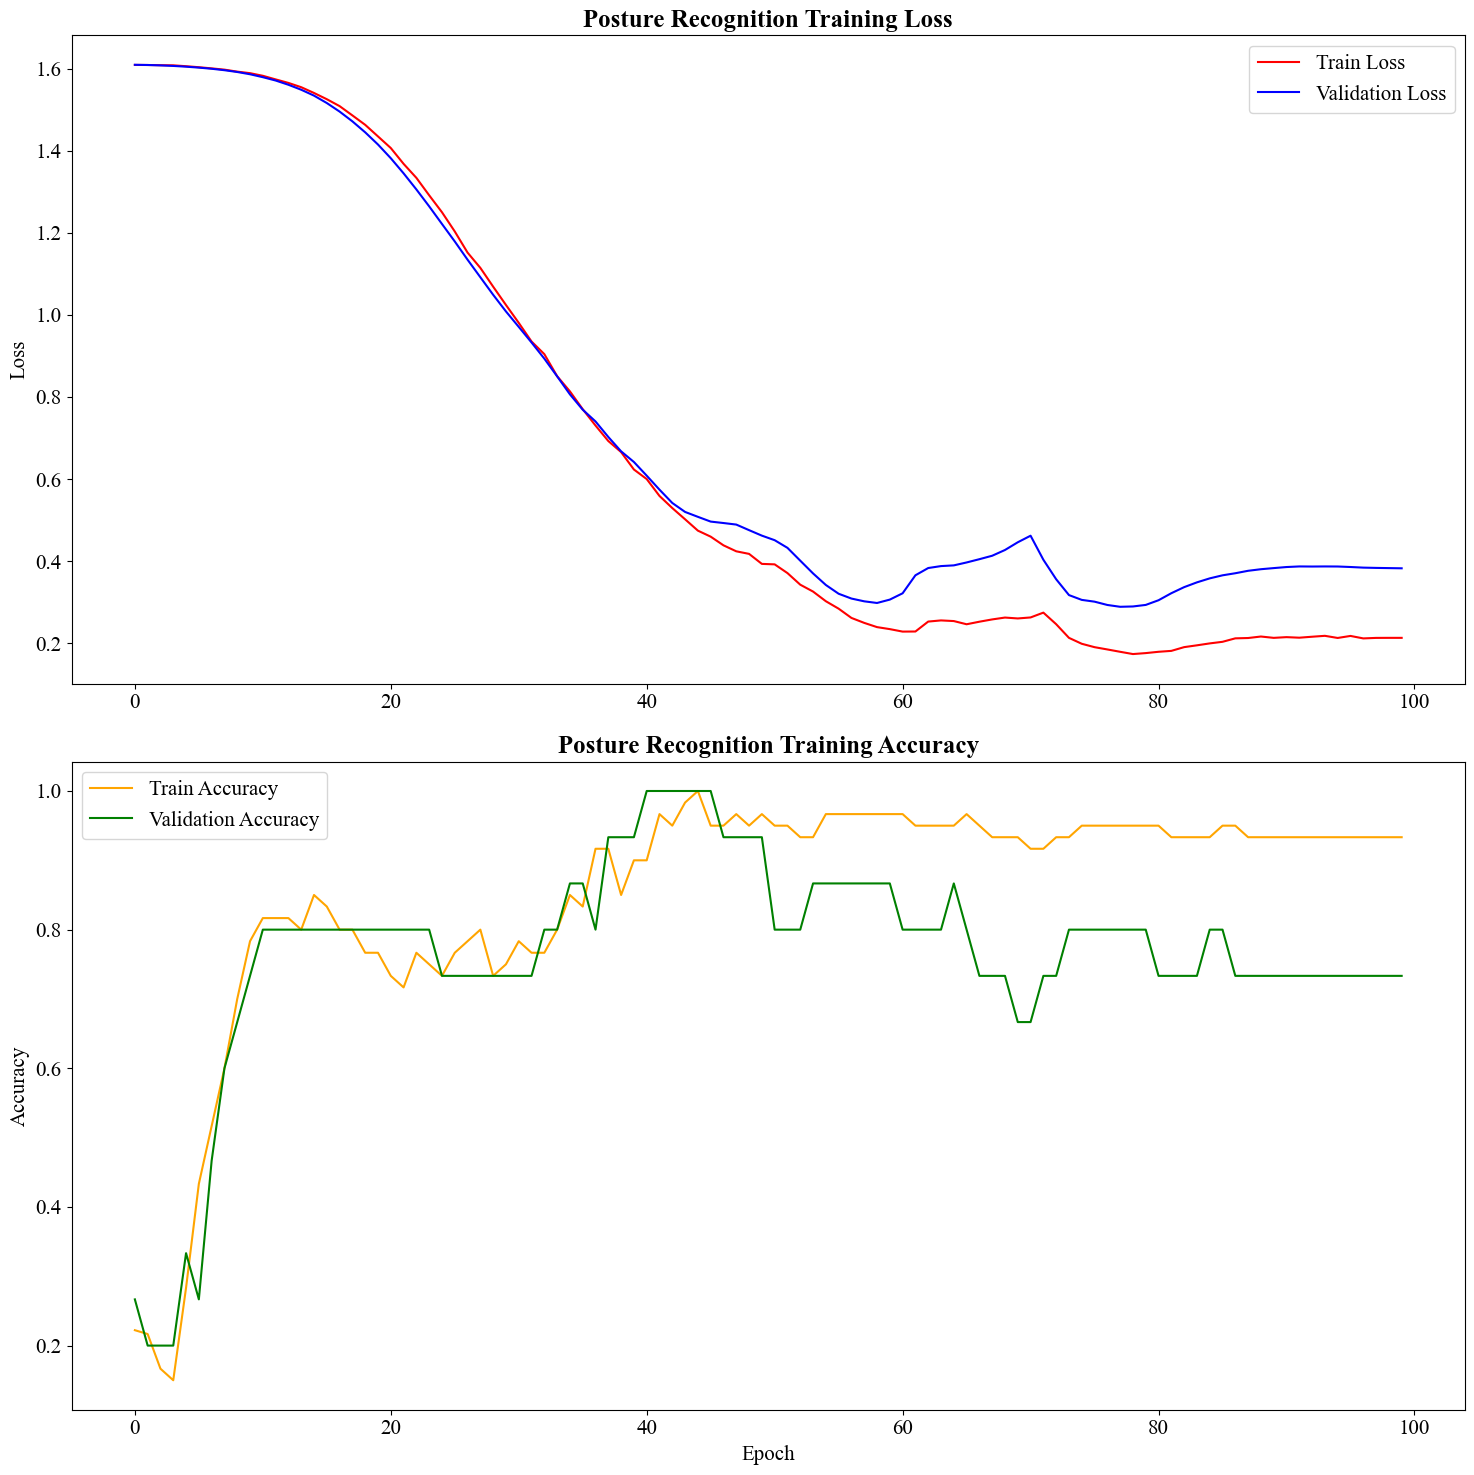

[INFO] Loading confusion matrix from: experiments/hand_pose/20250524/hand-pose-lstm-h128-l2\history_trainval.pkl


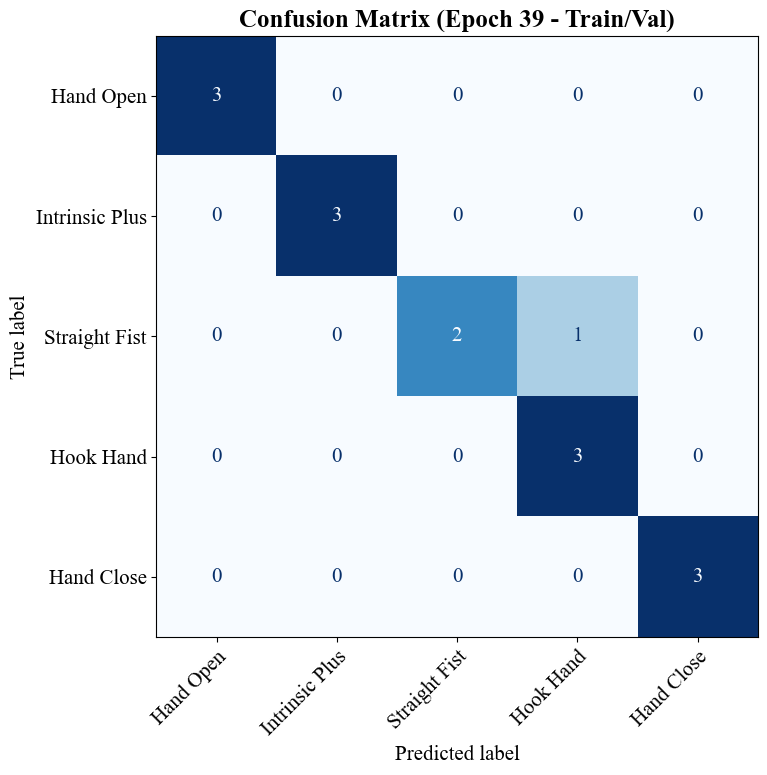

In [66]:
import pickle

# Load metrics
with open(f"{output_dir}/history_trainval.pkl", 'rb') as f:
    metrics_data = pickle.load(f)

print(metrics_data.keys())

def visualize_train_val_losses(save_dir: str) -> None:
    import pickle
    import matplotlib.pyplot as plt
    import glob
    import os

    # Set global font properties
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15

    # Search for history pickle files
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))

    for history_path in history_files:
        filename = os.path.basename(history_path)

        if "trainval" not in filename:
            continue  # skip non-trainval files

        print(f"Visualizing: {filename}")
        with open(history_path, "rb") as f:
            hist = pickle.load(f)

        fig, axs = plt.subplots(2, 1, figsize=(15, 15))

        # Plot loss
        axs[0].plot(hist["train_losses"], label="Train Loss", color='red')
        axs[0].plot(hist["eval_losses"], label="Validation Loss", color='blue')
        axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot accuracy
        axs[1].plot(hist["train_accuracies"], label="Train Accuracy", color='orange')
        axs[1].plot(hist["eval_accuracies"], label="Validation Accuracy", color='green')
        axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        plt.tight_layout()
        plt.show()
def visualize_confusion_matrix(save_dir: str, checkpoint: int, mode: str = "trainval", suffix: str = None) -> None:
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import glob
    import os
    # Look for the correct .pkl file based on mode
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))
    
    # If only one history file exists, use it regardless of name
    if len(history_files) == 1:
        matched_file = history_files[0]
    else:
        matched_file = None
        for file in history_files:
            if mode.lower() in os.path.basename(file).lower():
                matched_file = file
                break
                
    if not matched_file:
        print(f"[ERROR] No history file found in '{save_dir}' for mode '{mode}'")
        return
    
    print(f"[INFO] Loading confusion matrix from: {matched_file}")
    with open(matched_file, "rb") as f:
        hist = pickle.load(f)
    
    # Decide whether to use the last epoch or a single matrix
    if isinstance(hist["eval_confusion_matrices"], list):
        cm_data = hist["eval_confusion_matrices"][checkpoint]

        if suffix:
            title = f'Confusion Matrix (Epoch {checkpoint} - Train/Val) - {suffix}'
        else:
            title = f'Confusion Matrix (Epoch {checkpoint} - Train/Val)'
    else:
        print(f"[ERROR] Confusion matrix data not found in the history file.")

    
    cm = np.array(cm_data)
    class_names = [
        "Hand Open",
        "Intrinsic Plus",
        "Straight Fist",  
        "Hook Hand",
        "Hand Close",
    ]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight="bold")
    plt.tight_layout()
    
    plt.show()

visualize_train_val_losses(output_dir)
visualize_confusion_matrix(output_dir, checkpoint=39, mode='trainval')

## 3. Model Prediction

In [56]:
import numpy as np
import torch
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union, Any
import json
from tqdm import tqdm
import warnings
import logging
import mmcv
from mmdet.apis import inference_detector, init_detector
from mmpose.utils import adapt_mmdet_pipeline
from mmpose.evaluation.functional import nms
import albumentations as A

# Global model cache to avoid reloading models
MODEL_CACHE = {}

def detect_hands(img: Union[str, np.ndarray, List[Union[str, np.ndarray]]], 
                det_config: str = 'configs/rtmdet_nano_320-8xb32_hand.py',
                det_checkpoint: str = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth',
                device: str = 'cuda:0',
                det_cat_id: int = 0,
                bbox_thr: float = 0.3,
                nms_thr: float = 0.3,
                suppress_warnings: bool = True,
                input_size: Tuple[int, int] = (300, 300),
                crop_size: Tuple[int, int] = (600, 600),
                return_coordinates: str = 'original') -> Union[
                    Tuple[np.ndarray, np.ndarray, Dict[str, Any]],  # For 'original' mode
                    Tuple[np.ndarray, np.ndarray, Dict[str, Any], np.ndarray],  # For 'crop' or 'model' modes
                    List[Union[
                        Tuple[np.ndarray, np.ndarray, Dict[str, Any]],  # List of results in 'original' mode
                        Tuple[np.ndarray, np.ndarray, Dict[str, Any], np.ndarray]  # List of results in 'crop' or 'model' modes
                    ]]
                ]:
    """
    Detect hand bounding boxes in a single image or a list of images.
    
    Args:
        img: Image path, numpy array (RGB), or list of image paths/arrays.
        det_config: Path to detection config file.
        det_checkpoint: Path or URL to detection checkpoint.
        device: Device to run inference on.
        det_cat_id: Category ID for hands.
        bbox_thr: Threshold for bounding box confidence.
        nms_thr: Threshold for non-maximum suppression.
        suppress_warnings: Whether to suppress warning messages.
        input_size: Model input size (width, height), defaults to (300, 300)
        crop_size: Size for center crop (width, height), defaults to (600, 600)
        return_coordinates: Coordinate system for returned bounding boxes:
                          - 'original': In original input image coordinates (default)
                          - 'crop': In center-cropped image coordinates
                          - 'model': In model input size coordinates (300x300 by default)
        
    Returns:
        For a single image:
            bboxes: Numpy array of hand bounding boxes [x1, y1, x2, y2] in specified coordinate system
            scores: Numpy array of confidence scores
            crop_info: Dictionary with information about the crop (for transforming coordinates)
            processed_img: The cropped or model-sized image based on return_coordinates value
            
        For multiple images:
            List of tuples, where each tuple contains the above results for one image
    """
    global MODEL_CACHE
    
    # Validate return_coordinates parameter
    valid_return_options = ['original', 'crop', 'model']
    if return_coordinates not in valid_return_options:
        raise ValueError(f"return_coordinates must be one of {valid_return_options}, got {return_coordinates}")
    
    # Set up warning suppression if requested
    if suppress_warnings:
        # Filter warnings
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        # Filter mmengine and other library logs
        logging.getLogger('mmengine').setLevel(logging.ERROR)
        logging.getLogger('mmdet').setLevel(logging.ERROR)
        logging.getLogger('mmpose').setLevel(logging.ERROR)
        
        # Disable PyTorch CUDA warnings
        os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
    
    # Check if model is already in cache
    model_key = f"{det_config}_{det_checkpoint}_{device}"
    if model_key not in MODEL_CACHE:
        # Build detector
        detector = init_detector(det_config, det_checkpoint, device=device)
        detector.cfg = adapt_mmdet_pipeline(detector.cfg)
        MODEL_CACHE[model_key] = detector
    else:
        detector = MODEL_CACHE[model_key]
    
    # Define the processing function inside to maintain access to all variables
    def _process_single_image(current_img):
        # Convert image to numpy array if it's a path
        if isinstance(current_img, str):
            current_img = mmcv.imread(current_img, channel_order='rgb')
        elif isinstance(current_img, np.ndarray) and current_img.shape[-1] == 3:
            # Convert BGR to RGB if necessary
            if not isinstance(current_img, np.ndarray):
                current_img = np.array(current_img)
            current_img = mmcv.bgr2rgb(current_img)
        
        # Store original image dimensions
        original_height, original_width = current_img.shape[:2]
        
        # Apply center crop first to get the cropped image
        center_crop = A.CenterCrop(height=crop_size[1], width=crop_size[0])
        crop_result = center_crop(image=current_img)
        cropped_img = crop_result['image']
        
        # Calculate actual crop offsets based on original image dimensions
        crop_x_offset = max(0, (original_width - crop_size[0]) // 2)
        crop_y_offset = max(0, (original_height - crop_size[1]) // 2)
        
        # Now resize the cropped image to input size for the model
        resize_transform = A.Resize(height=input_size[1], width=input_size[0])
        resize_result = resize_transform(image=cropped_img)
        processed_img = resize_result['image']
        
        # Store crop information for coordinate mapping
        crop_info = {
            'original_size': (original_width, original_height),
            'crop_size': crop_size,
            'input_size': input_size,
            'crop_offset': (crop_x_offset, crop_y_offset)
        }
        
        # Detect hands (bounding boxes)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Suppress torch warnings
            torch._C._jit_set_profiling_executor(False)
            torch._C._jit_set_profiling_mode(False)
            
            det_result = inference_detector(detector, processed_img)
        
        pred_instance = det_result.pred_instances.cpu().numpy()
        
        # Extract bounding boxes with scores
        if len(pred_instance.bboxes) > 0:
            bboxes = np.concatenate(
                (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
            
            # Filter bboxes by category and score
            mask = np.logical_and(pred_instance.labels == det_cat_id,
                                pred_instance.scores > bbox_thr)
            bboxes = bboxes[mask]
            
            # Apply NMS
            if len(bboxes) > 0:
                keep_indices = nms(bboxes, nms_thr)
                filtered_bboxes = bboxes[keep_indices, :4]  # Just the coordinates
                filtered_scores = bboxes[keep_indices, 4]   # Just the scores
                
                # Map bounding boxes to appropriate coordinates based on user choice
                if len(filtered_bboxes) > 0:
                    # For 'model' coordinates, we keep the bounding boxes as is
                    if return_coordinates == 'model':
                        # Clip to model input boundaries (usually redundant but good practice)
                        filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, input_size[0])
                        filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, input_size[1])
                        filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, input_size[0])
                        filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, input_size[1])
                        
                    else:  # 'crop' or 'original'
                        # First scale from input_size to crop_size
                        scale_x = crop_size[0] / input_size[0]
                        scale_y = crop_size[1] / input_size[1]
                        
                        filtered_bboxes[:, 0] *= scale_x  # x1
                        filtered_bboxes[:, 1] *= scale_y  # y1
                        filtered_bboxes[:, 2] *= scale_x  # x2
                        filtered_bboxes[:, 3] *= scale_y  # y2
                        
                        # For 'crop' coordinates, clip to crop boundaries
                        if return_coordinates == 'crop':
                            filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, crop_size[0])
                            filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, crop_size[1])
                            filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, crop_size[0])
                            filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, crop_size[1])
                        
                        # For 'original' coordinates, add crop offsets and clip to original boundaries
                        elif return_coordinates == 'original':
                            filtered_bboxes[:, 0] += crop_x_offset  # x1
                            filtered_bboxes[:, 1] += crop_y_offset  # y1
                            filtered_bboxes[:, 2] += crop_x_offset  # x2
                            filtered_bboxes[:, 3] += crop_y_offset  # y3
                            
                            # Clip to original image boundaries
                            filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, original_width)
                            filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, original_height)
                            filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, original_width)
                            filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, original_height)
                
                # Return appropriate image along with results based on return_coordinates
                if return_coordinates == 'model':
                    return filtered_bboxes, filtered_scores, crop_info, processed_img
                elif return_coordinates == 'crop':
                    return filtered_bboxes, filtered_scores, crop_info, cropped_img
                else:  # 'original'
                    return filtered_bboxes, filtered_scores, crop_info
        
        # Return empty arrays if no detections, with appropriate image
        if return_coordinates == 'model':
            return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info, processed_img
        elif return_coordinates == 'crop':
            return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info, cropped_img
        else:  # 'original'
            return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info
    
    # Check if input is a list of images
    if isinstance(img, list):
        return [_process_single_image(single_img) for single_img in img]
    else:
        return _process_single_image(img)

from typing import Union, List, Tuple, Dict, Any, Optional
import numpy as np
import torch
from mmpose.apis import init_model as init_pose_estimator
from mmpose.apis import inference_topdown
from mmpose.structures import merge_data_samples

def pose(
    images: Union[np.ndarray, List[np.ndarray]],
    boxes: Union[np.ndarray, List[np.ndarray]],
    scores: Optional[Union[np.ndarray, List[np.ndarray]]] = None,
    pose_config: str = 'configs/rtmpose-m_8xb256-210e_hand5-256x256.py',
    pose_checkpoint: str = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth',
    device: str = 'cuda:0',
    normalize_keypoints: bool = False,
    return_full_samples: bool = False
) -> Union[Dict[str, Any], List[Dict[str, Any]]]:
    """
    Estimate pose keypoints for hand(s) in a single image or a list of images.
    
    Args:
        images: A single image or list of images (numpy arrays in RGB format)
        boxes: Bounding box(es) for hand detection either for a single image or matching the image list
        scores: Optional confidence scores for the bounding boxes
        pose_config: Path to pose estimation config file
        pose_checkpoint: Path or URL to pose estimation checkpoint
        device: Device to run inference on ('cuda:0', 'cpu', etc.)
        normalize_keypoints: Whether to normalize keypoint coordinates to 0-1 range
        return_full_samples: Whether to return the full data_samples or just the keypoints and scores
        
    Returns:
        For a single image:
            A dictionary containing:
                - 'keypoints': numpy array of shape (num_hands, num_keypoints, 2) with x,y coordinates
                - 'scores': numpy array of shape (num_hands, num_keypoints) with confidence scores
                - 'boxes': numpy array of shape (num_hands, 4) with bounding boxes
                - 'box_scores': numpy array of shape (num_hands) with bounding box confidence scores
                - (Optional) 'data_samples': full pose estimation results
                
        For multiple images:
            A list of dictionaries as described above, one for each image
    """
    global MODEL_CACHE
    
    # Initialize or get cached pose estimator
    model_key = f"{pose_config}_{pose_checkpoint}_{device}"
    if not hasattr(pose, 'MODEL_CACHE'):
        pose.MODEL_CACHE = {}
        
    if model_key not in pose.MODEL_CACHE:
        pose_estimator = init_pose_estimator(
            pose_config,
            pose_checkpoint,
            device=device
        )
        pose.MODEL_CACHE[model_key] = pose_estimator
    else:
        pose_estimator = pose.MODEL_CACHE[model_key]
    
    # Handle single image vs list of images
    is_single_image = not isinstance(images, list)
    
    if is_single_image:
        images = [images]
        boxes = [boxes]
        if scores is not None:
            scores = [scores]
    
    # Make sure each image has corresponding boxes
    assert len(images) == len(boxes), f"Number of images ({len(images)}) must match number of box sets ({len(boxes)})"
    
    # Process each image
    all_results = []
    
    for i, (image, image_boxes) in enumerate(zip(images, boxes)):
        # Skip processing if no hands detected
        if len(image_boxes) == 0:
            result = {
                'keypoints': np.empty((0, 21, 2), dtype=np.float32),
                'scores': np.empty((0, 21), dtype=np.float32),
                'boxes': np.empty((0, 4), dtype=np.float32),
                'box_scores': np.empty((0,), dtype=np.float32),
            }
            if return_full_samples:
                result['data_samples'] = None
            all_results.append(result)
            continue
            
        # Run pose estimation
        pose_results = inference_topdown(pose_estimator, image, image_boxes)
        data_samples = merge_data_samples(pose_results)
        
        # Extract keypoints and scores
        result = {}
        
        if hasattr(data_samples, 'pred_instances'):
            # Extract keypoints from pred_instances
            if hasattr(data_samples.pred_instances, 'keypoints'):
                keypoints = data_samples.pred_instances.keypoints
                keypoint_scores = data_samples.pred_instances.keypoint_scores
                
                # Normalize keypoint coordinates if requested
                if normalize_keypoints:
                    img_height, img_width = image.shape[:2]
                    keypoints[:, :, 0] /= img_width
                    keypoints[:, :, 1] /= img_height
                
                result['keypoints'] = keypoints
                result['scores'] = keypoint_scores
                result['boxes'] = image_boxes
                
                # Add box scores if available
                if scores is not None:
                    result['box_scores'] = scores[i]
                else:
                    # Default box scores to 1.0 if not provided
                    result['box_scores'] = np.ones(len(image_boxes), dtype=np.float32)
                
                if return_full_samples:
                    result['data_samples'] = data_samples
            else:
                # No keypoints detected
                result = {
                    'keypoints': np.empty((0, 21, 2), dtype=np.float32),
                    'scores': np.empty((0, 21), dtype=np.float32),
                    'boxes': image_boxes,
                    'box_scores': scores[i] if scores is not None else np.ones(len(image_boxes), dtype=np.float32),
                }
                if return_full_samples:
                    result['data_samples'] = data_samples
        else:
            # No instances detected
            result = {
                'keypoints': np.empty((0, 21, 2), dtype=np.float32),
                'scores': np.empty((0, 21), dtype=np.float32),
                'boxes': np.empty((0, 4), dtype=np.float32),
                'box_scores': np.empty((0,), dtype=np.float32),
            }
            if return_full_samples:
                result['data_samples'] = None
        
        all_results.append(result)
    
    # Return single result for single image input
    if is_single_image:
        return all_results[0]
    else:
        return all_results

def visualize_hand_landmarks(images: Union[np.ndarray, List[np.ndarray]], 
                           pose_results: Optional[Union[Dict[str, Any], List[Dict[str, Any]]]] = None,
                           keypoint_threshold: float = 0.3,
                           bbox_thickness: int = 2,
                           keypoint_radius: int = 4,
                           skeleton_thickness: int = 2,
                           show_bbox: bool = True,
                           show_keypoints: bool = True,
                           show_skeleton: bool = True,
                           show_keypoint_labels: bool = False,
                           show_confidence: bool = True,
                           show_handedness: bool = True,
                           backend: str = 'opencv') -> Union[np.ndarray, List[np.ndarray]]:
    """
    Visualize detected hand landmarks and bounding boxes on a single image or multiple images.
    
    Args:
        images: Input image(s) (numpy array or list of arrays in RGB format)
        pose_results: Results from the pose() function
                    For single image: Dictionary with 'keypoints', 'scores', 'boxes', 'box_scores'
                    For multiple images: List of dictionaries, one for each image
                    If None, no landmarks or boxes will be drawn
        keypoint_threshold: Minimum confidence threshold for displaying keypoints
        bbox_thickness: Thickness of bounding box lines
        keypoint_radius: Radius of keypoint circles
        skeleton_thickness: Thickness of skeleton lines
        show_bbox: Whether to show bounding boxes
        show_keypoints: Whether to show keypoints
        show_skeleton: Whether to show skeleton connections
        show_keypoint_labels: Whether to show keypoint labels
        show_confidence: Whether to show confidence scores
        show_handedness: Whether to show hand type (left/right prediction)
        backend: Backend to use for visualization ('opencv' or 'matplotlib')
        
    Returns:
        For single image: Visualized image with landmarks and bounding boxes
        For multiple images: List of visualized images
    """
    # Define hand keypoint connections for skeleton based on onehand10k dataset
    skeleton_connections = [
        # Thumb connections
        (0, 1), (1, 2), (2, 3), (3, 4),  
        # Index finger (forefinger) connections
        (0, 5), (5, 6), (6, 7), (7, 8),  
        # Middle finger connections
        (0, 9), (9, 10), (10, 11), (11, 12),  
        # Ring finger connections
        (0, 13), (13, 14), (14, 15), (15, 16),  
        # Pinky connections
        (0, 17), (17, 18), (18, 19), (19, 20)  
    ]
    
    # Keypoint names from onehand10k dataset
    keypoint_names = [
        "wrist", 
        "thumb1", "thumb2", "thumb3", "thumb4",
        "forefinger1", "forefinger2", "forefinger3", "forefinger4",
        "middle_finger1", "middle_finger2", "middle_finger3", "middle_finger4",
        "ring_finger1", "ring_finger2", "ring_finger3", "ring_finger4",
        "pinky_finger1", "pinky_finger2", "pinky_finger3", "pinky_finger4"
    ]
    
    # Keypoint colors from onehand10k dataset (BGR format for OpenCV)
    keypoint_colors = [
        (255, 255, 255),       # wrist - white
        (0, 128, 255),         # thumb1 - orange
        (0, 128, 255),         # thumb2 - orange
        (0, 128, 255),         # thumb3 - orange
        (0, 128, 255),         # thumb4 - orange
        (255, 153, 255),       # forefinger1 - pink
        (255, 153, 255),       # forefinger2 - pink
        (255, 153, 255),       # forefinger3 - pink
        (255, 153, 255),       # forefinger4 - pink
        (255, 178, 102),       # middle_finger1 - light blue
        (255, 178, 102),       # middle_finger2 - light blue
        (255, 178, 102),       # middle_finger3 - light blue
        (255, 178, 102),       # middle_finger4 - light blue
        (51, 51, 255),         # ring_finger1 - red
        (51, 51, 255),         # ring_finger2 - red
        (51, 51, 255),         # ring_finger3 - red
        (51, 51, 255),         # ring_finger4 - red
        (0, 255, 0),           # pinky_finger1 - green
        (0, 255, 0),           # pinky_finger2 - green
        (0, 255, 0),           # pinky_finger3 - green
        (0, 255, 0)            # pinky_finger4 - green
    ]
    
    # Skeleton colors from onehand10k dataset (BGR format for OpenCV)
    skeleton_colors = [
        # Thumb connections
        (0, 128, 255), (0, 128, 255), (0, 128, 255), (0, 128, 255),
        # Index (forefinger) connections
        (255, 153, 255), (255, 153, 255), (255, 153, 255), (255, 153, 255),
        # Middle finger connections
        (255, 178, 102), (255, 178, 102), (255, 178, 102), (255, 178, 102),
        # Ring finger connections
        (51, 51, 255), (51, 51, 255), (51, 51, 255), (51, 51, 255),
        # Pinky connections
        (0, 255, 0), (0, 255, 0), (0, 255, 0), (0, 255, 0)
    ]
    
    # Default bbox color in BGR
    bbox_color = (0, 255, 0)  # Green
    
    # Check if input is a single image or a list of images
    is_single_image = not isinstance(images, list)
    
    # If single image, convert to list format to unify processing
    if is_single_image:
        images_list = [images]
        # If pose_results is provided and is a dict, convert to list
        if pose_results is not None and isinstance(pose_results, dict):
            pose_results_list = [pose_results]
        else:
            pose_results_list = None
    else:
        # For multiple images
        images_list = images
        # If pose_results is provided, use it
        pose_results_list = pose_results if isinstance(pose_results, list) else None
    
    # Process each image
    result_images = []
    
    for i, image in enumerate(images_list):
        # Make a copy of the image to avoid modifying the original
        vis_image = image.copy()
        
        # Convert RGB to BGR for OpenCV
        if vis_image.shape[2] == 3 and backend == 'opencv':
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)
        
        # Skip processing if no pose results
        if pose_results_list is None or i >= len(pose_results_list) or pose_results_list[i] is None:
            # Just add the original image to the result and continue
            if vis_image.shape[2] == 3 and backend == 'opencv':
                vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
            result_images.append(vis_image)
            continue
        
        # Get pose results for this image
        result = pose_results_list[i]
        
        # Extract keypoints, bboxes and scores
        keypoints_array = result.get('keypoints', None)
        keypoint_scores = result.get('scores', None)
        current_bboxes = result.get('boxes', None)
        current_scores = result.get('box_scores', None)
        
        # Skip if no keypoints or bboxes
        if (keypoints_array is None or len(keypoints_array) == 0) and (current_bboxes is None or len(current_bboxes) == 0):
            if vis_image.shape[2] == 3 and backend == 'opencv':
                vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
            result_images.append(vis_image)
            continue
        
        # Draw bounding boxes if available and requested
        if show_bbox and current_bboxes is not None and len(current_bboxes) > 0:
            for idx, box in enumerate(current_bboxes):
                x1, y1, x2, y2 = box.astype(int)
                
                # Draw the bounding box
                cv2.rectangle(vis_image, (x1, y1), (x2, y2), bbox_color, bbox_thickness)
                
                # Add confidence score if requested
                if show_confidence and current_scores is not None and idx < len(current_scores):
                    score = current_scores[idx]
                    conf_text = f"Conf: {score:.2f}"
                    text_size = cv2.getTextSize(conf_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                    cv2.rectangle(vis_image, 
                                (x1, y1 - text_size[1] - 5), 
                                (x1 + text_size[0], y1), 
                                bbox_color, -1)
                    cv2.putText(vis_image, conf_text, (x1, y1 - 5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        # Draw keypoints and skeleton if available and requested
        if (show_keypoints or show_skeleton) and keypoints_array is not None and len(keypoints_array) > 0:
            for hand_idx, hand_keypoints in enumerate(keypoints_array):
                # Skip hands with no valid keypoints
                if len(hand_keypoints) == 0:
                    continue
                
                # Get scores for this hand
                hand_scores = keypoint_scores[hand_idx] if keypoint_scores is not None else np.ones(hand_keypoints.shape[0])
                
                # Create list of valid keypoints
                valid_keypoints = []
                for j, (kp, score) in enumerate(zip(hand_keypoints, hand_scores)):
                    if score >= keypoint_threshold:
                        x, y = int(kp[0]), int(kp[1])
                        valid_keypoints.append((j, x, y, score))
                
                # Draw skeleton if requested
                if show_skeleton:
                    # Create a dictionary for quick access to keypoint coordinates
                    kp_dict = {idx: (x, y) for idx, x, y, _ in valid_keypoints}
                    
                    # Draw connections
                    for j, connection in enumerate(skeleton_connections):
                        idx1, idx2 = connection
                        if idx1 in kp_dict and idx2 in kp_dict:
                            pt1 = kp_dict[idx1]
                            pt2 = kp_dict[idx2]
                            # Use the color specific to this connection
                            color = skeleton_colors[j] if j < len(skeleton_colors) else (255, 255, 255)
                            cv2.line(vis_image, pt1, pt2, color, skeleton_thickness)
                
                # Draw keypoints if requested
                if show_keypoints:
                    for idx, x, y, conf in valid_keypoints:
                        # Use the color specific to this keypoint
                        color = keypoint_colors[idx] if idx < len(keypoint_colors) else (255, 255, 255)
                        
                        # Draw keypoint circle with filled center
                        cv2.circle(vis_image, (x, y), keypoint_radius, color, -1)
                        
                        # Add a small border to make keypoints more visible
                        cv2.circle(vis_image, (x, y), keypoint_radius, (0, 0, 0), 1)
                        
                        # Add keypoint labels if requested
                        if show_keypoint_labels and idx < len(keypoint_names):
                            label = f"{keypoint_names[idx]}"
                            if show_confidence:
                                label += f" ({conf:.2f})"
                            
                            # Place text near the keypoint
                            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
                            
                            # Create a dark background for text
                            cv2.rectangle(vis_image, 
                                        (x + 5, y - text_size[1] - 5), 
                                        (x + 5 + text_size[0], y), 
                                        (0, 0, 0), -1)
                            
                            # Add text label
                            cv2.putText(vis_image, label, (x + 5, y - 5), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                
                # Determine handedness if requested
                if show_handedness and len(valid_keypoints) > 0:
                    # Simplified handedness estimation using keypoint positions
                    wrist_idx = 0
                    thumb_tip_idx = 4
                    index_tip_idx = 8
                    
                    # Create a dictionary of keypoint positions
                    kp_positions = {idx: (x, y) for idx, x, y, _ in valid_keypoints}
                    
                    hand_type = "Unknown"
                    
                    # Check if we have the necessary keypoints
                    if wrist_idx in kp_positions and thumb_tip_idx in kp_positions and index_tip_idx in kp_positions:
                        wrist = kp_positions[wrist_idx]
                        thumb_tip = kp_positions[thumb_tip_idx]
                        index_tip = kp_positions[index_tip_idx]
                        
                        # Calculate vectors from wrist to fingertips
                        wrist_to_thumb = (thumb_tip[0] - wrist[0], thumb_tip[1] - wrist[1])
                        wrist_to_index = (index_tip[0] - wrist[0], index_tip[1] - wrist[1])
                        
                        # Cross product to determine if thumb is to the left or right of index finger
                        cross_product = wrist_to_thumb[0] * wrist_to_index[1] - wrist_to_thumb[1] * wrist_to_index[0]
                        
                        # If cross product is positive, thumb is to the right of index finger (likely left hand)
                        # If negative, thumb is to the left of index finger (likely right hand)
                        if cross_product > 0:
                            hand_type = "Left"
                        else:
                            hand_type = "Right"
                    
                    # Add hand type text
                    hand_text = f"{hand_type} Hand"
                    
                    if current_bboxes is not None and hand_idx < len(current_bboxes):
                        x1, y1, x2, y2 = current_bboxes[hand_idx].astype(int)
                        
                        text_size = cv2.getTextSize(hand_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                        
                        # Place text above the bounding box
                        text_y = y1 - text_size[1] - 15 if show_confidence else y1 - text_size[1] - 5
                        text_x = x1
                        
                        cv2.rectangle(vis_image, 
                                    (text_x, text_y - text_size[1]), 
                                    (text_x + text_size[0], text_y + 5), 
                                    (0, 0, 255), -1)  # Blue background
                        cv2.putText(vis_image, hand_text, (text_x, text_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    else:
                        # If no bounding box, place text at the wrist position
                        if wrist_idx in kp_positions:
                            wrist_x, wrist_y = kp_positions[wrist_idx]
                            text_size = cv2.getTextSize(hand_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                            cv2.rectangle(vis_image, 
                                        (wrist_x, wrist_y - text_size[1] - 15), 
                                        (wrist_x + text_size[0], wrist_y - 10), 
                                        (0, 0, 255), -1)  # Blue background
                            cv2.putText(vis_image, hand_text, (wrist_x, wrist_y - 15), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Convert back to RGB if needed
        if vis_image.shape[2] == 3 and backend == 'opencv':
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
        
        # Add the processed image to the result list
        result_images.append(vis_image)
    
    # Return a single image if input was a single image, otherwise return the list
    if is_single_image:
        return result_images[0]
    else:
        return result_images

In [63]:
def sliding_window_sample(images, window_size=16, stride=8):
    """
    Create sliding windows from a sequence of frames.
    
    Args:
        images: List of frames or numpy array of shape [T, H, W, C]
        window_size: Number of frames in each window
        stride: Step size between windows
        
    Returns:
        List of numpy arrays, each with shape [window_size, H, W, C]
    """
    total_frames = len(images)
    windows = []
    
    # Handle case where there aren't enough frames for a single window
    if total_frames < window_size:
        # Duplicate the last frame to reach window_size
        padding_needed = window_size - total_frames
        padded_images = list(images) + [images[-1]] * padding_needed
        windows.append(np.stack(padded_images))
        return windows
    
    # Create windows with stride
    for start_idx in range(0, total_frames - window_size + 1, stride):
        end_idx = start_idx + window_size
        # Make a copy to ensure contiguous memory
        window = np.ascontiguousarray(np.stack(images[start_idx:end_idx]))
        windows.append(window)
    
    # If the last window doesn't align with the stride, add one more window
    # that takes the last window_size frames
    if (total_frames - window_size) % stride != 0:
        last_start = total_frames - window_size
        if last_start > (start_idx + stride):  # Only if it's different enough from the last added window
            window = np.ascontiguousarray(np.stack(images[last_start:]))
            windows.append(window)
    
    return windows

def process_window_poses(window_frames: np.ndarray, 
                        detect_hands_fn, 
                        pose_fn,
                        normalize: str = 'wrist') -> Tuple[np.ndarray, List[Dict], List[Dict]]:
    """
    Process a window of frames to extract hand poses.
    
    Args:
        window_frames: Array of shape (window_size, H, W, C)
        detect_hands_fn: Hand detection function
        pose_fn: Pose estimation function
        normalize: Normalization method ('wrist', 'bbox', or None)
        
    Returns:
        pose_sequence: Array of shape (window_size, 42) - flattened keypoints
        pose_results: List of pose detection results for visualization
        hand_boxes: List of hand detection results
    """
    window_size = len(window_frames)
    num_keypoints = 21
    
    # Detect hands for all frames
    boxes_list = []
    scores_list = []
    crop_info_list = []
    
    for frame in window_frames:
        boxes, scores, crop_info = detect_hands_fn(
            frame,
            return_coordinates='original',
            crop_size=(300, 300),
        )
        boxes_list.append(boxes)
        scores_list.append(scores)
        crop_info_list.append(crop_info)
    
    # Convert to list for pose function
    frames_list = [frame for frame in window_frames]
    
    # Get pose results
    pose_results = pose_fn(
        images=frames_list,
        boxes=boxes_list,
        scores=scores_list
    )
    
    # Extract pose coordinates
    pose_sequence = []
    
    for frame_idx, result in enumerate(pose_results):
        frame_keypoints = np.zeros((num_keypoints, 2))
        
        if result is not None:
            if isinstance(result, dict) and 'keypoints' in result:
                keypoints = result['keypoints']
                if isinstance(keypoints, np.ndarray) and keypoints.size > 0:
                    if keypoints.shape == (1, num_keypoints, 2):
                        frame_keypoints = keypoints[0].copy()
                    elif keypoints.shape == (num_keypoints, 2):
                        frame_keypoints = keypoints.copy()
        
        pose_sequence.append(frame_keypoints)
    
    pose_sequence = np.array(pose_sequence)  # Shape: (window_size, 21, 2)
    
    # Normalize if requested
    if normalize == 'wrist':
        for i in range(window_size):
            if np.any(pose_sequence[i] != 0):
                wrist_pos = pose_sequence[i, 0, :]
                pose_sequence[i] = pose_sequence[i] - wrist_pos
    elif normalize == 'bbox':
        for i in range(window_size):
            if np.any(pose_sequence[i] != 0):
                valid_mask = ~np.all(pose_sequence[i] == 0, axis=1)
                if np.any(valid_mask):
                    valid_points = pose_sequence[i][valid_mask]
                    min_vals = valid_points.min(axis=0)
                    max_vals = valid_points.max(axis=0)
                    range_vals = max_vals - min_vals
                    range_vals[range_vals == 0] = 1
                    
                    for j in range(len(pose_sequence[i])):
                        if valid_mask[j]:
                            pose_sequence[i, j] = (pose_sequence[i, j] - min_vals) / range_vals
    
    # Flatten to (window_size, 42)
    pose_sequence_flat = pose_sequence.reshape(window_size, -1)
    
    return pose_sequence_flat, pose_results, boxes_list

def load_model(model_path: str, device: str = 'cuda'):
    """
    Load the trained LSTM model.
    
    Args:
        model_path: Path to the model directory
        device: Device to load model on ('cuda' or 'cpu')
        
    Returns:
        model: Loaded model
        config: Model configuration
        id2label: Mapping from class ID to label name
    """
    # Load configuration
    config_path = Path(model_path).parent / 'training_config.json'
    if config_path.exists():
        with open(config_path, 'r') as f:
            training_config = json.load(f)
            class_names = training_config.get('class_names', {})
            id2label = {str(k): v for k, v in class_names.items()}
    else:
        # Default mapping
        id2label = {
            '0': 'OH',  # Open Hand
            '1': 'IH',  # Intrinsic Plus
            '2': 'SF',  # Straight Fist
            '3': 'HC',  # Hook Hand
            '4': 'HH'   # Hand Close
        }
    
    # Load model
    model = LSTMForSequenceClassification.from_pretrained(model_path)
    model = model.to(device)
    model.eval()
    
    return model, model.config, id2label

def add_prediction_label(image: np.ndarray, 
                        label: str, 
                        confidence: float,
                        position: str = 'top-left') -> np.ndarray:
    """
    Add prediction label with black background to image.
    
    Args:
        image: Input image
        label: Predicted label text
        confidence: Prediction confidence
        position: Position of label ('top-left', 'top-right', 'bottom-left', 'bottom-right')
        
    Returns:
        Image with label added
    """
    # Create a copy to avoid modifying original
    result = image.copy()
    
    # Prepare text
    text = f"{label} ({confidence:.2%})"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    thickness = 2
    
    # Get text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    
    # Calculate position
    padding = 10
    if position == 'top-left':
        x = padding
        y = padding + text_height
    elif position == 'top-right':
        x = image.shape[1] - text_width - padding
        y = padding + text_height
    elif position == 'bottom-left':
        x = padding
        y = image.shape[0] - padding
    elif position == 'bottom-right':
        x = image.shape[1] - text_width - padding
        y = image.shape[0] - padding
    else:
        x = padding
        y = padding + text_height
    
    # Draw black rectangle background
    cv2.rectangle(result, 
                  (x - 5, y - text_height - 5), 
                  (x + text_width + 5, y + baseline + 5), 
                  (0, 0, 0), 
                  -1)
    
    # Draw white text
    cv2.putText(result, text, (x, y), font, font_scale, (255, 255, 255), thickness)
    
    return result

def predict_hand_gestures(
    cropped_video_path: str,
    model_path: str,
    detect_hands_fn,
    pose_fn,
    visualize_fn,
    output_video_path: Optional[str] = None,
    window_size: int = 16,
    stride: int = 8,
    normalize: str = 'wrist',
    device: str = 'cuda',
    show_progress: bool = True
) -> Dict[str, Any]:
    """
    Complete pipeline for hand gesture prediction on video.
    
    Args:
        cropped_video_path: Path to cropped hands sequence (.npy file)
        model_path: Path to trained model directory
        detect_hands_fn: Hand detection function
        pose_fn: Pose estimation function
        visualize_fn: Visualization function (visualize_hand_landmarks)
        output_video_path: Path to save output video (optional)
        window_size: Number of frames per window
        stride: Stride for sliding window
        normalize: Normalization method ('wrist', 'bbox', or None)
        device: Device for inference ('cuda' or 'cpu')
        show_progress: Whether to show progress bar
        
    Returns:
        Dictionary with predictions and statistics
    """
    # Load the video frames
    print(f"Loading video from {cropped_video_path}")
    frames = np.load(cropped_video_path)
    print(f"Loaded {len(frames)} frames of shape {frames[0].shape}")
    
    # Load the model
    print(f"\nLoading model from {model_path}")
    model, config, id2label = load_model(model_path, device)
    
    # Create sliding windows
    print(f"\nCreating sliding windows (size={window_size}, stride={stride})")
    windows = sliding_window_sample(frames, window_size=window_size, stride=stride)
    print(f"Created {len(windows)} windows")
    
    # Process each window
    predictions = []
    all_pose_results = []
    all_boxes = []
    
    # Setup progress bar
    iterator = tqdm(windows, desc="Processing windows") if show_progress else windows
    
    for window_idx, window in enumerate(iterator):
        # Extract poses for this window
        pose_sequence, pose_results, boxes = process_window_poses(
            window, detect_hands_fn, pose_fn, normalize=normalize
        )
        
        # Store results for visualization
        all_pose_results.append(pose_results)
        all_boxes.append(boxes)
        
        # Prepare input for model
        with torch.no_grad():
            # Convert to tensor and add batch dimension
            input_tensor = torch.FloatTensor(pose_sequence).unsqueeze(0).to(device)
            
            # Get prediction
            outputs = model(input_ids=input_tensor)
            logits = outputs.logits
            
            # Get probabilities and prediction
            probs = torch.softmax(logits, dim=-1)
            pred_class = logits.argmax(dim=-1).item()
            confidence = probs[0, pred_class].item()
            
            # Store prediction
            predictions.append({
                'window_idx': window_idx,
                'start_frame': window_idx * stride,
                'end_frame': window_idx * stride + window_size,
                'predicted_class': pred_class,
                'predicted_label': id2label[str(pred_class)],
                'confidence': confidence,
                'probabilities': probs[0].cpu().numpy().tolist()
            })
    
    print(f"\nPredictions complete. Processing visualization...")
    
    # Create visualized frames
    visualized_frames = []
    
    for frame_idx, frame in enumerate(frames):
        # Find which window(s) this frame belongs to
        frame_predictions = []
        frame_pose_results = None
        
        for window_idx, pred in enumerate(predictions):
            if pred['start_frame'] <= frame_idx < pred['end_frame']:
                frame_predictions.append(pred)
                # Get the pose result for this frame within the window
                window_frame_idx = frame_idx - pred['start_frame']
                if window_frame_idx < len(all_pose_results[window_idx]):
                    frame_pose_results = all_pose_results[window_idx][window_frame_idx]
        
        # Visualize hand landmarks
        if frame_pose_results is not None:
            vis_frame = visualize_fn(
                frame,
                frame_pose_results,
                show_bbox=True,
                show_keypoints=True,
                show_skeleton=True,
                show_confidence=False,
                keypoint_threshold=0,
                show_handedness=False
            )
        else:
            vis_frame = frame.copy()
        
        # Add prediction labels
        if frame_predictions:
            # Use the most recent prediction
            latest_pred = frame_predictions[-1]
            vis_frame = add_prediction_label(
                vis_frame,
                latest_pred['predicted_label'],
                latest_pred['confidence'],
                position='top-left'
            )
        
        visualized_frames.append(vis_frame)
    
    # Save output video if requested
    if output_video_path:
        print(f"\nSaving output video to {output_video_path}")
        height, width = visualized_frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 30  # Adjust based on your needs
        
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        
        for frame in visualized_frames:
            # Convert RGB to BGR for OpenCV
            bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(bgr_frame)
        
        out.release()
        print(f"Video saved successfully")
    
    # Calculate statistics
    label_counts = {}
    for pred in predictions:
        label = pred['predicted_label']
        label_counts[label] = label_counts.get(label, 0) + 1
    
    # Prepare results
    results = {
        'predictions': predictions,
        'visualized_frames': visualized_frames,
        'statistics': {
            'total_frames': len(frames),
            'total_windows': len(windows),
            'window_size': window_size,
            'stride': stride,
            'label_distribution': label_counts,
            'average_confidence': np.mean([p['confidence'] for p in predictions])
        },
        'model_info': {
            'model_path': model_path,
            'class_mapping': id2label,
            'normalization': normalize
        }
    }
    
    return results

In [64]:
# Run prediction
results = predict_hand_gestures(
    cropped_video_path="cropped_hands_sequence.npy",
    model_path=r"D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\hand_pose\20250524\hand-pose-lstm-h128-l2\checkpoint-41",
    detect_hands_fn=detect_hands,
    pose_fn=pose,
    visualize_fn=visualize_hand_landmarks,
    output_video_path="output_predictions.mp4",
    window_size=16,
    stride=16,
    normalize='wrist',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Loading video from cropped_hands_sequence.npy
Loaded 105 frames of shape (300, 300, 3)

Loading model from D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\hand_pose\20250524\hand-pose-lstm-h128-l2\checkpoint-41

Creating sliding windows (size=16, stride=16)
Created 6 windows


Processing windows: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Predictions complete. Processing visualization...

Saving output video to output_predictions.mp4
Video saved successfully
